#### Notebook `Feature Selection`

#### Group:
- `Miguel Matos - 20221925`
- `André Nicolau - 20221861`
- `André Ferreira - 20250398`

---

#### <font> Table of Contents </font> <a class="anchor" id='toc'></a> 
1. [Imports](#Imports)
2. [Feature Selection](#feature-selection)

 - 2.1.[Correlation Matrix](#correlation-matrix)
 - 2.2.[Chi-Square Test on Categorical variables](#chi-square-test-on-categorical-variables)
 - 2.3.[Wrapper Methods](#wrapper-methods)
 - 2.4.[Embedded Methods](#embedded-methods)


# Imports
[Back to TOC](#toc)

In [4]:
from functions import *

In [5]:
X_train = pd.read_csv("../data/Split_data/X_train.csv", index_col= "carID")
y_train = pd.read_csv("../data/Split_data/y_train.csv", index_col= "carID")

X_val = pd.read_csv("../data/Split_data/X_val.csv", index_col= "carID")
y_val = pd.read_csv("../data/Split_data/y_val.csv", index_col= "carID")

#For testing categorical variables
X_categoricals = pd.read_csv("../data/data_cleaned.csv", index_col= "carID")

pd.set_option("display.max_columns", None)

# Feature Selection
[Back to TOC](#toc)


Let's start by creating a dictionary that will be used to count the amoung of times a variables is pointed to be deleted or not.

In [6]:
variable_scoreboard = {column: 0 for column in X_train.columns}
variable_scoreboard

{'car_age': 0,
 'mileage': 0,
 'tax': 0,
 'mpg': 0,
 'engineSize': 0,
 'paintQuality%': 0,
 'previousOwners': 0,
 'Audi': 0,
 'BMW': 0,
 'Ford': 0,
 'Hyundai': 0,
 'Mercedes': 0,
 'Opel': 0,
 'Skoda': 0,
 'Toyota': 0,
 'VW': 0,
 'Diesel': 0,
 'Hybrid': 0,
 'Petrol': 0,
 'Automatic': 0,
 'Manual': 0,
 'Semi-Auto': 0}

## Correlation Matrix

Firstly, let's take a look a highly correlated features that can give us an insight for which variables to drop.

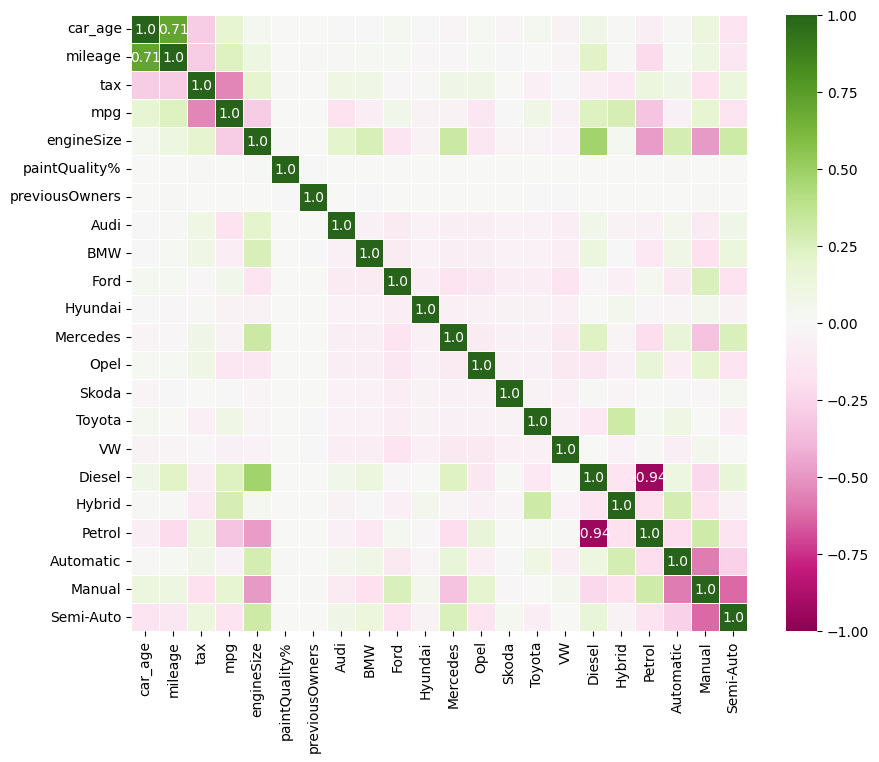

In [7]:
correlation_matrix(X_train, 0.7)

- "car_age" and "mileage" have a high correlation, of 71%, but we still need to look at other feature selection techniques to get more insights and to decide whether either "car_age" or "mileage" are up to remove.

- "Diesel" and "Petrol" have a really high correlation of 94%, which means one of them will very likely be eliminated.

In [8]:
variable_scoreboard["car_age"] += 1
variable_scoreboard["mileage"] += 1
variable_scoreboard["Diesel"] += 1
variable_scoreboard["Petrol"] += 1

## Chi-Square Test on Categorical variables

For this test, we'll use the dataset cleaned, but not yet encoded or scaled.

In [9]:
X_categoricals = X_categoricals.select_dtypes(exclude= np.number)
indexes = X_train.index.to_list() #Getting the indexes of the X_train
X_train_cat = X_categoricals.loc[indexes] # Getting only the rows that correspond to X_train
X_train_cat.head()

,Brand,model,transmission,fuelType
carID,,,,
31106,Ford,Focus,Unknown,Diesel
52908,Toyota,Avensis,Manual,Diesel
21218,Ford,Focus,Manual,Petrol
15728,Ford,Fiesta,Manual,Petrol
68286,VW,Sharan,Semi-Auto,Diesel


In [10]:
# Transforming y_train into a Series
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]

In [11]:
for var in X_train_cat:
    TestIndependence(X_train_cat[var],y_train, var)

Brand is IMPORTANT for Prediction
model is IMPORTANT for Prediction
transmission is IMPORTANT for Prediction
fuelType is IMPORTANT for Prediction


Looks like all the categorical variables are important for the model.

## Wrapper Methods

In the following steps, we'll use the wrapper method Recursive Feature Elimination (RFE), employing a Linear Regression model as the base estimator to select the most relevant features.

In [12]:
model = LinearRegression()
len(X_train.columns)

22

In the following cell we apply Recursive Feature Elimination (RFE) with Linear Regression to determine the optimal number of features.
We test different feature counts, evaluate each model’s R² on the training and validation sets, and track which subset gives the best validation performance.
Finally, we report the number of selected features and the corresponding best score.

In [13]:
#no of features
nof_list=np.arange(1,len(X_train.columns)+1)            
high_score=0

#Variable to store the optimum features
nof=0           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    model = LinearRegression()
    
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_val_rfe = rfe.transform(X_val)
    model.fit(X_train_rfe,y_train)
    
    #storing results on training data
    train_score = model.score(X_train_rfe,y_train)
    train_score_list.append(train_score)
    
    #storing results on validation data
    val_score = model.score(X_val_rfe,y_val)
    val_score_list.append(val_score)
    
    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 22
Score with 22 features: 0.717746


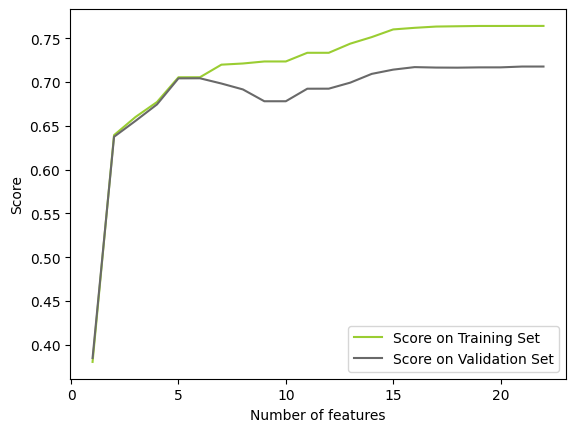

In [14]:
plt.plot(list(range(1,23)), train_score_list, label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(1,23)), val_score_list, label="Score on Validation Set", color='dimgray')
plt.xlabel("Number of features")
plt.ylabel("Score")
plt.legend()
plt.show()

Using a RFE with Linear regression, seems that every feature is important as the best score was with all the features.

##  Embedded Methods

### Lasso Regression

First we'll create a lasso model, fit it in the train model and obtain the feature coefficients.

In [15]:
reg = LassoCV()
reg.fit(X_train, y_train)
coef = pd.Series(reg.coef_, index = X_train.columns)

In [16]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 18 variables and eliminated the other 4 variables


In [17]:
coef.sort_values()

car_age          -4100.153881
mpg              -2749.163166
mileage          -2434.433204
Manual           -2037.847299
Petrol            -832.862123
tax               -437.922519
Opel              -304.715696
Toyota            -200.963555
Hyundai           -182.390809
Skoda             -137.423948
Ford               -58.173835
previousOwners       0.000000
paintQuality%       -0.000000
Diesel              -0.000000
Automatic            0.000000
VW                  18.354763
BMW                275.251873
Mercedes           309.948070
Audi               415.363722
Semi-Auto          851.976183
Hybrid            3850.405255
engineSize        5668.831107
dtype: float64

After getting the features coefficients, we'll plot them in a way that's easier to visualize which are important and which aren't.

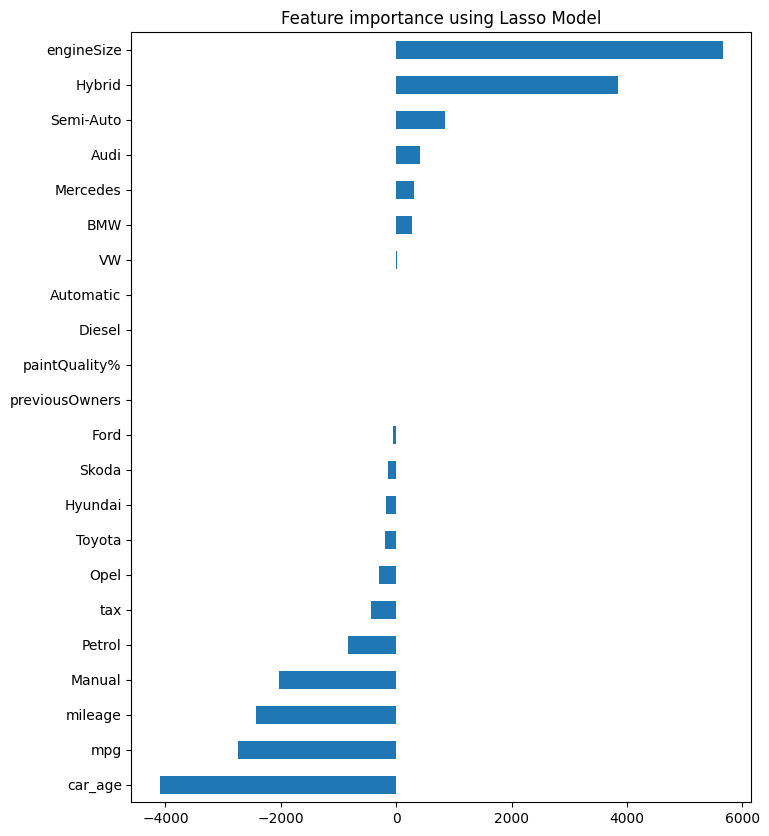

In [18]:
# CODE HERE
plot_importance(coef,'Lasso')

Based on the embbeded method Lasso, "previousOwners", "paintQuality%", "Diesel" and "Automatic" are insignificant, as their coefficient is equal to 0.

In [19]:
variable_scoreboard["previousOwners"] += 1
variable_scoreboard["paintQuality%"] += 1
variable_scoreboard["Diesel"] += 1
variable_scoreboard["Automatic"] += 1

### Ridge Regression

This time, we'll use Ridge Regression for a different approach and to get more insights.

In [20]:
reg = Ridge()
reg.fit(X_train, y_train)
coef = pd.Series(reg.coef_, index = X_train.columns)

In [21]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables.")

Lasso picked 22 variables and eliminated the other 0 variables.


In [22]:
coef.sort_values()

car_age          -4112.576998
mpg              -2860.309619
mileage          -2440.830977
Petrol           -1996.991617
Diesel           -1087.154227
tax               -468.420366
Opel              -307.098346
Toyota            -215.695188
Hyundai           -191.554072
Skoda             -146.474288
Ford               -59.142280
paintQuality%      -27.406490
previousOwners      14.617947
VW                  16.349323
BMW                273.930510
Mercedes           309.466941
Audi               413.512707
Manual             635.710045
Automatic         2592.095837
Hybrid            3387.402863
Semi-Auto         3552.986094
engineSize        5646.573290
dtype: float64

Once again, we'll plot the the coefficients for easier interpretation.

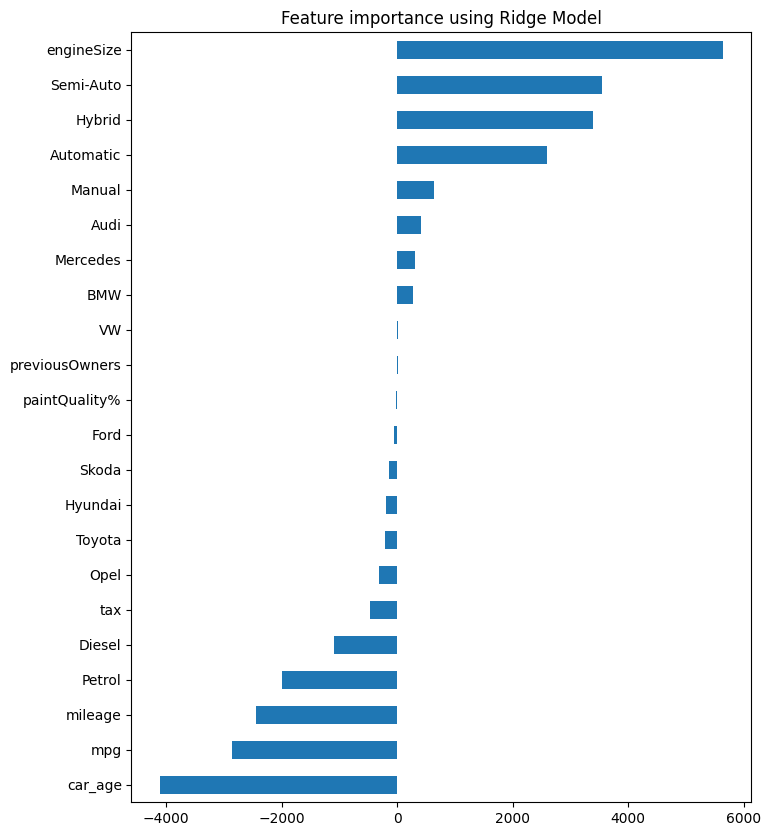

In [23]:
# CODE HERE
plot_importance(coef,'Ridge')

In [24]:
#Adding a point to the variables that are pointed to delete.
variable_scoreboard["previousOwners"] += 1
variable_scoreboard["paintQuality%"] += 1
variable_scoreboard["VW"] += 1

Now, let's divide the counts we got in the dictionary by 4, which is the number of different approaches we did, and see how much in percentage, each variable was pointed to delete.

In [25]:
final_scoreboard = {key: np.round(value/4, 2) for key, value in variable_scoreboard.items() if np.round(value/4, 2) >= 0.5}

In [26]:
final_scoreboard

{'paintQuality%': 0.5, 'previousOwners': 0.5, 'Diesel': 0.5}

So, these three variables in half of the four trials we did to check if the variables where relevant or not for the model, were told to be discarded.

For this reason we'll build a model with and without them, and see if it gives better better results.